In [6]:
# ==========================================================================
# Cell: Setup & Dependencies - Install PyTorch3D
# ============================================================================

import sys
import subprocess
import os
import shutil
from typing import Tuple

print("=" * 60)
print("INSTALLATION & ENVIRONMENT SETUP")
print("=" * 60)
print(f"Python: {sys.version}")
print(f"Working directory: {os.getcwd()}")

# Install base dependencies
subprocess.run([sys.executable, "-m", "pip", "install", "-q",
                "torch", "torchvision", "numpy", "opencv-python",
                "matplotlib", "scipy", "Pillow"], check=False)

# ============================================================================
# Platform-aware PyTorch3D Installation Helper (embedded sse_env.py)
# ============================================================================

def _run(cmd: list, check: bool = True) -> int:
    """Run a command (list form). Returns exit code."""
    print("$", " ".join(cmd))
    try:
        return subprocess.run(cmd, check=check).returncode
    except subprocess.CalledProcessError as e:
        print(f"Command failed with code {e.returncode}: {' '.join(cmd)}")
        if check:
            raise
        return e.returncode

def _pip_install(*pkgs: str, extra_args: list = None, check: bool = True) -> int:
    args = [sys.executable, "-m", "pip", "install"]
    if extra_args:
        args += extra_args
    args += list(pkgs)
    return _run(args, check=check)

def _apt_available() -> bool:
    return shutil.which("apt-get") is not None

def _sudo_prefix() -> list:
    return ["sudo"] if shutil.which("sudo") else []

def _is_colab() -> bool:
    try:
        import google.colab
        return True
    except Exception:
        return "content" in os.getcwd()

class PlatformManager:
    def __init__(self):
        self.platform, self.local_path = self.detect_platform()

    @staticmethod
    def mount_gdrive():
        """Mount Google Drive in Colab (noop elsewhere)."""
        if _is_colab():
            try:
                from google.colab import drive
                drive.mount('/content/drive')
            except Exception as e:
                print(f"Failed to mount Google Drive: {e}")
        else:
            print("Google Drive mount is only applicable in Colab.")

    @staticmethod
    def detect_platform() -> Tuple[str, str]:
        """Detect platform and return its name and the local path"""
        computing_platform = 'LocalPC'

        if os.getenv('RUNPOD_POD_ID'):
            computing_platform = "RunPod"
            print("Running on RunPod.")
            local_path = "/workspace/"
        elif 'content' in str(os.getcwd()):
            computing_platform = "Colab"
            print("Running on Colab.")
            local_path = "/content/"
        elif os.getenv("LIGHTNING_ARTIFACTS_DIR"):
            computing_platform = "LightningAI"
            print("Running on Lightning AI Studio")
            local_path = os.getenv("LIGHTNING_ARTIFACTS_DIR") + '/'
        else:
            local_path = os.getcwd() + '/'

        return computing_platform, local_path

class DependencyInstaller:
    @staticmethod
    def install_glut(computing_platform: str):
        _pip_install("--upgrade", "pip", extra_args=[], check=False)

        if not _apt_available():
            print("apt-get not available on this system; skipping GL/GLUT dev packages.")
            return

        apt = _sudo_prefix() + ["apt-get"]
        if computing_platform in {"LightningAI", "RunPod", "Colab", "LocalPC"}:
            _run(apt + ["-qq", "update"], check=False)
            _run(apt + ["install", "-y",
                        "freeglut3-dev", "libglew-dev", "libsdl2-dev"], check=False)

    @staticmethod
    def install_opengl():
        try:
            _pip_install("PyOpenGL", "PyOpenGL_accelerate", extra_args=[], check=True)
        except Exception as e:
            print(f"Failed to install OpenGL: {e}")

    @staticmethod
    def get_pytorch3d_version_string() -> str:
        """Compose the official PyTorch3D wheel tag."""
        import torch
        pyt_version_str = torch.__version__.split("+")[0].replace(".", "")
        cuda_ver = getattr(torch.version, "cuda", None)
        if not cuda_ver:
            return None
        version_str = "".join([
            f"py3{sys.version_info.minor}_cu",
            cuda_ver.replace(".", ""),
            f"_pyt{pyt_version_str}"
        ])
        return version_str

class PyTorch3DInstaller:
    def __init__(self, computing_platform: str, local_path: str):
        self.platform = computing_platform
        self.local_path = local_path

    def install(self):
        need_pytorch3d = False

        _pip_install("--upgrade", "pip", extra_args=[], check=False)
        DependencyInstaller.install_glut(self.platform)
        DependencyInstaller.install_opengl()

        version_str = DependencyInstaller.get_pytorch3d_version_string()
        print(f"\nPyTorch3D target wheel tag: {version_str}\n")

        _pip_install("iopath", extra_args=[], check=False)

        if sys.platform.startswith("linux") and version_str:
            print(f"Trying to install PyTorch3D wheel on {self.platform} (Linux).")
            try:
                if self.platform in {"RunPod", "LightningAI"}:
                    index_url = f"https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html"
                    _pip_install("pytorch3d",
                                 extra_args=["--no-index", "--no-cache-dir", "-f", index_url],
                                 check=True)

                elif self.platform == "Colab":
                    wheel_url = ("https://www.dropbox.com/scl/fi/fqvlnyponcbekjd01omhj/"
                                 "pytorch3d-0.7.8-cp312-cp312-linux_x86_64.whl"
                                 "?rlkey=563mfx35rog42z1c8y7qn31sk&dl=1")
                    _pip_install(wheel_url, extra_args=[], check=True)

                else:
                    index_url = f"https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html"
                    _pip_install("pytorch3d",
                                 extra_args=["--no-index", "--no-cache-dir", "-f", index_url],
                                 check=True)
            except Exception as e:
                print(f"Wheel install failed: {e}")
                need_pytorch3d = True
        else:
            need_pytorch3d = True

        try:
            import pytorch3d
            print("✅ PyTorch3D successfully installed!")
            need_pytorch3d = False
        except Exception:
            need_pytorch3d = True

        if need_pytorch3d:
            print("Falling back to source install for PyTorch3D (this may take a while).")
            _pip_install("ninja", extra_args=["--root-user-action", "ignore"], check=False)
            _pip_install("git+https://github.com/facebookresearch/pytorch3d.git@stable",
                         extra_args=[], check=True)
            try:
                import pytorch3d
            except Exception:
                print("❌ PyTorch3D failed to install from source.")
            else:
                print("✅ PyTorch3D successfully installed from source.")

# ============================================================================
# Run PyTorch3D Installation
# ============================================================================

pm = PlatformManager()
print(f"\nDetected platform: {pm.platform}")
print(f"Local path: {pm.local_path}")

installer = PyTorch3DInstaller(pm.platform, pm.local_path)
installer.install()

print("\n✓ Done.")

INSTALLATION & ENVIRONMENT SETUP
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Working directory: /content
Running on Colab.

Detected platform: Colab
Local path: /content/
$ /usr/bin/python3 -m pip install --upgrade pip
$ /usr/bin/python3 -m pip install --upgrade pip
$ sudo apt-get -qq update
$ sudo apt-get install -y freeglut3-dev libglew-dev libsdl2-dev
$ /usr/bin/python3 -m pip install PyOpenGL PyOpenGL_accelerate

PyTorch3D target wheel tag: py312_cu126_pyt280

$ /usr/bin/python3 -m pip install iopath
Trying to install PyTorch3D wheel on Colab (Linux).
$ /usr/bin/python3 -m pip install https://www.dropbox.com/scl/fi/fqvlnyponcbekjd01omhj/pytorch3d-0.7.8-cp312-cp312-linux_x86_64.whl?rlkey=563mfx35rog42z1c8y7qn31sk&dl=1
✅ PyTorch3D successfully installed!

✓ Done.


In [7]:
print("Installing required packages...")
!pip install -q torch torchvision
!pip install -q fvcore iopath
!pip install -q --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py38_cu117_pyt1110/download.html
!pip install -q gradio opencv-python matplotlib numpy scipy

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy.spatial.transform import Rotation as R
import gradio as gr
import io
import base64

# PyTorch3D imports
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    PerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    BlendParams,
)
from pytorch3d.utils import ico_sphere
from pytorch3d.io import load_objs_as_meshes

print("✓ All packages installed successfully!")

Installing required packages...
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'fvcore' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'fvcore'. Discussion can be found at https://github.com/pypa/pip/issues/6334
✓ All packages installed successfully!


In [8]:
class CameraPoseEstimator:
    """
    Estimates camera pose from a planar object using perspective transformation.
    Based on Assignment 2 concepts - extended for AR applications.
    """

    def __init__(self, image_width, image_height, focal_length=None):
        """
        Initialize pose estimator

        Args:
            image_width: Width of the image in pixels
            image_height: Height of the image in pixels
            focal_length: Camera focal length (if None, estimates from FOV)
        """
        self.image_width = image_width
        self.image_height = image_height

        # Estimate focal length if not provided (assuming 60° FOV)
        if focal_length is None:
            fov_deg = 60
            self.focal_length = (image_width / 2) / np.tan(np.radians(fov_deg / 2))
        else:
            self.focal_length = focal_length

        # Camera intrinsic matrix
        self.K = np.array([
            [self.focal_length, 0, image_width / 2],
            [0, self.focal_length, image_height / 2],
            [0, 0, 1]
        ], dtype=np.float32)

    def compute_reprojection_error(self, object_points, image_points, R, tvec):
        """
        Compute reprojection error (RMSE) for pose estimation validation

        Args:
            object_points: 3D points in world coordinates
            image_points: 2D points in image coordinates
            R: Rotation matrix
            tvec: Translation vector

        Returns:
            rmse: Root Mean Square Error
            reprojected_points: Reprojected 2D points
            errors: Per-point errors
        """
        # Convert rotation matrix to rotation vector
        rvec, _ = cv2.Rodrigues(R)

        # Project 3D points to 2D
        reprojected_points, _ = cv2.projectPoints(
            object_points, rvec, tvec.reshape(3, 1), self.K, None
        )
        reprojected_points = reprojected_points.reshape(-1, 2)

        # Compute per-point errors
        errors = np.linalg.norm(image_points - reprojected_points, axis=1)

        # Compute RMSE
        rmse = np.sqrt(np.mean(errors ** 2))

        return rmse, reprojected_points, errors

    def estimate_pose_from_plane(self, image_points, real_world_size=(0.3, 0.2)):
        """
        Estimate camera pose from 4 corners of a planar rectangle

        Args:
            image_points: 4x2 array of corner points in image [top-left, top-right, bottom-right, bottom-left]
            real_world_size: (width, height) of the plane in meters

        Returns:
            R: 3x3 rotation matrix (extrinsics)
            t: 3x1 translation vector (extrinsics)
            plane_normal: Normal vector of the plane
            object_points: 3D world coordinates
            rmse: Reprojection RMSE error
            reprojected_points: Reprojected corner points
        """
        # Define 3D points of the plane in world coordinates (on Z=0 plane)
        width, height = real_world_size
        object_points = np.array([
            [0, 0, 0],           # top-left
            [width, 0, 0],       # top-right
            [width, height, 0],  # bottom-right
            [0, height, 0]       # bottom-left
        ], dtype=np.float32)

        # Ensure image points are float32
        image_points = np.array(image_points, dtype=np.float32)

        # Use solvePnP to estimate pose
        success, rvec, tvec = cv2.solvePnP(
            object_points,
            image_points,
            self.K,
            None,
            flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not success:
            raise ValueError("Failed to estimate camera pose")

        # Convert rotation vector to rotation matrix
        R_mat, _ = cv2.Rodrigues(rvec)

        # The plane normal in camera coordinates is the third column of R
        plane_normal = R_mat[:, 2]

        # Compute reprojection error
        rmse, reprojected_points, per_point_errors = self.compute_reprojection_error(
            object_points, image_points, R_mat, tvec.flatten()
        )

        return R_mat, tvec.flatten(), plane_normal, object_points, rmse, reprojected_points

    def get_camera_matrices_for_pytorch3d(self, R_mat, tvec):
        """
        Convert OpenCV camera parameters to PyTorch3D format

        Args:
            R_mat: 3x3 rotation matrix (OpenCV convention)
            tvec: 3x1 translation vector

        Returns:
            R_pytorch3d: Rotation matrix in PyTorch3D convention
            T_pytorch3d: Translation vector in PyTorch3D convention
        """
        # PyTorch3D uses a different coordinate system than OpenCV
        # OpenCV: +X right, +Y down, +Z forward
        # PyTorch3D: +X left, +Y up, +Z forward

        # Conversion matrix
        coord_transform = np.array([
            [-1, 0, 0],
            [0, -1, 0],
            [0, 0, 1]
        ], dtype=np.float32)

        # Transform rotation and translation
        R_pytorch3d = coord_transform @ R_mat
        T_pytorch3d = coord_transform @ tvec

        return R_pytorch3d, T_pytorch3d

    def get_camera_parameters_text(self, R, t):
        """
        Format camera parameters for display

        Args:
            R: Rotation matrix (extrinsics)
            t: Translation vector (extrinsics)

        Returns:
            formatted_text: Human-readable camera parameters
        """
        # Extract rotation angles (Euler angles)
        from scipy.spatial.transform import Rotation as Rot
        euler_angles = Rot.from_matrix(R).as_euler('xyz', degrees=True)

        # Camera center in world coordinates
        C = -R.T @ t

        text = f"""
📷 CAMERA INTRINSICS (K):
  fx = {self.K[0,0]:.2f} px  (focal length X)
  fy = {self.K[1,1]:.2f} px  (focal length Y)
  cx = {self.K[0,2]:.2f} px  (principal point X)
  cy = {self.K[1,2]:.2f} px  (principal point Y)

  Matrix K:
  [{self.K[0,0]:8.2f}  {self.K[0,1]:8.2f}  {self.K[0,2]:8.2f}]
  [{self.K[1,0]:8.2f}  {self.K[1,1]:8.2f}  {self.K[1,2]:8.2f}]
  [{self.K[2,0]:8.2f}  {self.K[2,1]:8.2f}  {self.K[2,2]:8.2f}]

📐 CAMERA EXTRINSICS:

  Rotation Matrix R:
  [{R[0,0]:8.4f}  {R[0,1]:8.4f}  {R[0,2]:8.4f}]
  [{R[1,0]:8.4f}  {R[1,1]:8.4f}  {R[1,2]:8.4f}]
  [{R[2,0]:8.4f}  {R[2,1]:8.4f}  {R[2,2]:8.4f}]

  Translation Vector t:
  [{t[0]:8.4f}, {t[1]:8.4f}, {t[2]:8.4f}] meters

  Euler Angles (X, Y, Z):
  Roll  (X): {euler_angles[0]:7.2f}°
  Pitch (Y): {euler_angles[1]:7.2f}°
  Yaw   (Z): {euler_angles[2]:7.2f}°

  Camera Center in World:
  [{C[0]:8.4f}, {C[1]:8.4f}, {C[2]:8.4f}] meters
"""
        return text

In [9]:
def create_cube_mesh(device, size=0.15, color=[0.0, 0.5, 1.0]):
    """Create a cube mesh - INCREASED base size for better visibility"""
    # Define cube vertices
    vertices = torch.tensor([
        [-1, -1, -1], [1, -1, -1], [1, 1, -1], [-1, 1, -1],  # back face
        [-1, -1, 1], [1, -1, 1], [1, 1, 1], [-1, 1, 1]       # front face
    ], dtype=torch.float32, device=device) * size / 2

    # Define cube faces
    faces = torch.tensor([
        [0, 1, 2], [0, 2, 3],  # back
        [4, 6, 5], [4, 7, 6],  # front
        [0, 4, 5], [0, 5, 1],  # bottom
        [2, 6, 7], [2, 7, 3],  # top
        [0, 3, 7], [0, 7, 4],  # left
        [1, 5, 6], [1, 6, 2]   # right
    ], dtype=torch.int64, device=device)

    # Create vertex colors
    verts_rgb = torch.tensor([color] * vertices.shape[0], dtype=torch.float32, device=device)
    textures = TexturesVertex(verts_features=[verts_rgb])

    return Meshes(verts=[vertices], faces=[faces], textures=textures)


def create_sphere_mesh(device, radius=0.08, color=[1.0, 0.0, 0.5]):
    """Create a sphere mesh - INCREASED base radius for better visibility"""
    mesh = ico_sphere(3, device)

    # Scale to desired radius
    verts = mesh.verts_list()[0] * radius
    faces = mesh.faces_list()[0]

    # Create vertex colors
    verts_rgb = torch.tensor([color] * verts.shape[0], dtype=torch.float32, device=device)
    textures = TexturesVertex(verts_features=[verts_rgb])

    return Meshes(verts=[verts], faces=[faces], textures=textures)


def create_teapot_mesh(device, size=0.12, color=[0.0, 1.0, 0.5]):
    """Create a teapot-like shape - INCREASED base size for better visibility"""
    # Create main body (sphere)
    mesh = ico_sphere(3, device)
    verts = mesh.verts_list()[0]

    # Scale and deform to teapot shape
    verts = verts * size
    verts[:, 2] = verts[:, 2] * 0.7  # flatten slightly

    faces = mesh.faces_list()[0]

    # Create vertex colors
    verts_rgb = torch.tensor([color] * verts.shape[0], dtype=torch.float32, device=device)
    textures = TexturesVertex(verts_features=[verts_rgb])

    return Meshes(verts=[verts], faces=[faces], textures=textures)


def create_pyramid_mesh(device, size=0.15, color=[1.0, 1.0, 0.0]):
    """Create a pyramid mesh - INCREASED base size for better visibility"""
    h = size
    base = size * 0.8

    vertices = torch.tensor([
        [0, h, 0],                    # apex
        [-base/2, 0, -base/2],        # base corners
        [base/2, 0, -base/2],
        [base/2, 0, base/2],
        [-base/2, 0, base/2]
    ], dtype=torch.float32, device=device)

    faces = torch.tensor([
        [0, 1, 2], [0, 2, 3], [0, 3, 4], [0, 4, 1],  # sides
        [1, 3, 2], [1, 4, 3]  # base
    ], dtype=torch.int64, device=device)

    verts_rgb = torch.tensor([color] * vertices.shape[0], dtype=torch.float32, device=device)
    textures = TexturesVertex(verts_features=[verts_rgb])

    return Meshes(verts=[vertices], faces=[faces], textures=textures)


In [10]:
class ARRenderer:
    """Augmented Reality Renderer using PyTorch3D"""

    def __init__(self, image_width, image_height, focal_length, device):
        self.device = device
        self.image_width = image_width
        self.image_height = image_height
        self.focal_length = focal_length

    def setup_renderer(self, R, T, light_intensity=0.8):
        """
        Setup PyTorch3D renderer with camera parameters

        Args:
            R: 3x3 rotation matrix
            T: 3x1 translation vector
            light_intensity: Intensity of lighting (0-1)
        """
        # Convert to PyTorch tensors
        R_tensor = torch.tensor(R, dtype=torch.float32, device=self.device).unsqueeze(0)
        T_tensor = torch.tensor(T, dtype=torch.float32, device=self.device).unsqueeze(0)

        # Calculate focal length in NDC coordinates
        focal_ndc = 2.0 * self.focal_length / min(self.image_width, self.image_height)

        # Create camera with intrinsics
        cameras = PerspectiveCameras(
            device=self.device,
            R=R_tensor,
            T=T_tensor,
            focal_length=((focal_ndc, focal_ndc),),
            principal_point=((0.0, 0.0),),
            image_size=((self.image_height, self.image_width),),
            in_ndc=True
        )

        # Setup rasterization
        raster_settings = RasterizationSettings(
            image_size=(self.image_height, self.image_width),
            blur_radius=0.0,
            faces_per_pixel=1,
            bin_size=0
        )

        # Setup lighting
        lights = PointLights(
            device=self.device,
            location=[[0.0, 1.0, -2.0]],
            ambient_color=((light_intensity, light_intensity, light_intensity),),
            diffuse_color=((0.6, 0.6, 0.6),),
            specular_color=((0.3, 0.3, 0.3),)
        )

        # Create renderer
        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras,
                raster_settings=raster_settings
            ),
            shader=SoftPhongShader(
                device=self.device,
                cameras=cameras,
                lights=lights,
                blend_params=BlendParams(background_color=(0.0, 0.0, 0.0))
            )
        )

        return renderer, cameras

    def render_object_on_plane(self, mesh, renderer, position, rotation_angles=(0, 0, 0)):
        """
        Render 3D object at specified position on plane

        Args:
            mesh: PyTorch3D mesh object
            renderer: PyTorch3D renderer
            position: (x, y, z) position on plane
            rotation_angles: (rx, ry, rz) rotation in degrees

        Returns:
            rendered_image: RGBA image with transparency
        """
        # Apply transformations
        verts = mesh.verts_list()[0].clone()

        # Apply rotation
        if any(rotation_angles):
            rotation_matrix = torch.tensor(
                R.from_euler('xyz', rotation_angles, degrees=True).as_matrix(),
                dtype=torch.float32,
                device=self.device
            )
            verts = torch.matmul(verts, rotation_matrix.T)

        # Apply translation
        position_tensor = torch.tensor(position, dtype=torch.float32, device=self.device)
        verts = verts + position_tensor

        # Create new mesh with transformed vertices
        transformed_mesh = Meshes(
            verts=[verts],
            faces=mesh.faces_list(),
            textures=mesh.textures
        )

        # Render
        with torch.no_grad():
            rendered = renderer(transformed_mesh)

        return rendered[0, ..., :3].cpu().numpy()

    def composite_with_background(self, background_image, rendered_image, alpha_threshold=0.01):
        """
        Composite rendered object with background image

        Args:
            background_image: Background image (RGB)
            rendered_image: Rendered object image (RGB)
            alpha_threshold: Threshold for transparency

        Returns:
            composited_image: Final AR image
        """
        # Convert to numpy if needed
        if torch.is_tensor(background_image):
            background_image = background_image.cpu().numpy()
        if torch.is_tensor(rendered_image):
            rendered_image = rendered_image.cpu().numpy()

        # Normalize if needed
        if background_image.max() > 1.0:
            background_image = background_image / 255.0
        if rendered_image.max() > 1.0:
            rendered_image = rendered_image / 255.0

        # Create alpha mask (where rendered object exists)
        alpha = (rendered_image.sum(axis=2) > alpha_threshold).astype(np.float32)
        alpha = np.expand_dims(alpha, axis=2)

        # Composite
        composited = background_image * (1 - alpha) + rendered_image * alpha

        return composited

In [11]:
# Global variables for state management
global_state = {
    'image': None,
    'corners': [],
    'planes': [],
    'pose_estimator': None,
    'renderer': None,
    'device': None,
    'last_R': None,
    'last_t': None,
    'last_rmse': None,
    'last_reprojected': None
}

def process_image_upload(image):
    """Process uploaded image"""
    global global_state

    if image is None:
        return None, "Please upload an image", None

    # Store image
    global_state['image'] = np.array(image)
    global_state['corners'] = []
    global_state['planes'] = []

    # Setup device
    global_state['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create pose estimator
    h, w = global_state['image'].shape[:2]
    global_state['pose_estimator'] = CameraPoseEstimator(w, h)

    return image, f"✓ Image loaded ({w}x{h}). Click on 4 corners to define plane.", None


def visualize_reprojection_error(image, corners, reprojected_points, rmse):
    """Create visualization of reprojection errors"""
    vis_img = image.copy()

    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    labels = ['TL', 'TR', 'BR', 'BL']

    # Draw original corners (larger circles)
    for i, (cx, cy) in enumerate(corners):
        cv2.circle(vis_img, (int(cx), int(cy)), 10, colors[i], -1)
        cv2.putText(vis_img, labels[i], (int(cx)+15, int(cy)-15),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, colors[i], 2)

    # Draw reprojected corners (smaller circles with 'X')
    for i, (cx, cy) in enumerate(reprojected_points):
        cv2.circle(vis_img, (int(cx), int(cy)), 6, (255, 255, 255), 2)
        cv2.drawMarker(vis_img, (int(cx), int(cy)), (0, 0, 0),
                      cv2.MARKER_CROSS, 10, 2)

    # Draw error lines
    for i in range(len(corners)):
        pt1 = (int(corners[i][0]), int(corners[i][1]))
        pt2 = (int(reprojected_points[i][0]), int(reprojected_points[i][1]))
        cv2.line(vis_img, pt1, pt2, (255, 0, 255), 2)

        # Calculate and display individual error
        error = np.linalg.norm(corners[i] - reprojected_points[i])
        mid_x = int((corners[i][0] + reprojected_points[i][0]) / 2)
        mid_y = int((corners[i][1] + reprojected_points[i][1]) / 2)
        cv2.putText(vis_img, f"{error:.1f}px", (mid_x, mid_y),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 2)

    # Add RMSE text
    cv2.putText(vis_img, f"RMSE: {rmse:.2f} pixels", (10, 30),
               cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)

    return vis_img


def add_corner(image, evt: gr.SelectData):
    """Add corner point when user clicks on image"""
    global global_state

    if global_state['image'] is None:
        return image, "Please upload an image first", None

    x, y = evt.index
    global_state['corners'].append([x, y])

    # Draw corners on image
    img_with_corners = global_state['image'].copy()

    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    labels = ['TL', 'TR', 'BR', 'BL']

    for i, (cx, cy) in enumerate(global_state['corners']):
        cv2.circle(img_with_corners, (cx, cy), 8, colors[i], -1)
        cv2.putText(img_with_corners, labels[i], (cx+10, cy-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, colors[i], 2)

    # Draw lines between corners
    if len(global_state['corners']) > 1:
        for i in range(len(global_state['corners'])):
            j = (i + 1) % len(global_state['corners'])
            if j < len(global_state['corners']):
                cv2.line(img_with_corners,
                        tuple(global_state['corners'][i]),
                        tuple(global_state['corners'][j]),
                        (0, 255, 255), 2)

    msg = f"Corner {len(global_state['corners'])}/4 added"

    if len(global_state['corners']) == 4:
        msg = "✓ All 4 corners defined! Now you can render objects."
        # Store this plane
        global_state['planes'].append({
            'corners': global_state['corners'].copy(),
            'active': True
        })

    return img_with_corners, msg, None


def reset_corners():
    """Reset corner selection"""
    global global_state
    global_state['corners'] = []

    if global_state['image'] is not None:
        return global_state['image'].copy(), "Corners reset. Click 4 new corners.", None, None
    return None, "Corners reset", None, None


def render_ar_scene(object_type, position_x, position_y, position_z,
                   size_scale, rotation_x, rotation_y, rotation_z,
                   light_intensity, plane_width, plane_height):
    """Main rendering function with enhanced feedback"""
    global global_state

    if global_state['image'] is None:
        return None, "Please upload an image first", None, None

    if len(global_state['corners']) != 4:
        return global_state['image'], "Please select 4 corners first", None, None

    try:
        device = global_state['device']
        pose_estimator = global_state['pose_estimator']

        # Estimate camera pose from plane
        corners = np.array(global_state['corners'], dtype=np.float32)
        R_cv, t_cv, plane_normal, object_points, rmse, reprojected_points = pose_estimator.estimate_pose_from_plane(
            corners,
            real_world_size=(plane_width, plane_height)
        )

        # Store for visualization
        global_state['last_R'] = R_cv
        global_state['last_t'] = t_cv
        global_state['last_rmse'] = rmse
        global_state['last_reprojected'] = reprojected_points

        # Convert to PyTorch3D format
        R_pt3d, T_pt3d = pose_estimator.get_camera_matrices_for_pytorch3d(R_cv, t_cv)

        # Setup renderer
        ar_renderer = ARRenderer(
            pose_estimator.image_width,
            pose_estimator.image_height,
            pose_estimator.focal_length,
            device
        )

        renderer, cameras = ar_renderer.setup_renderer(R_pt3d, T_pt3d, light_intensity)

        # Create 3D object based on selection
        object_colors = {
            'Cube': [0.0, 0.5, 1.0],
            'Sphere': [1.0, 0.0, 0.5],
            'Teapot': [0.0, 1.0, 0.5],
            'Pyramid': [1.0, 1.0, 0.0]
        }

        color = object_colors.get(object_type, [0.5, 0.5, 0.5])

        # FIXED: Use the new base sizes
        if object_type == 'Cube':
            mesh = create_cube_mesh(device, size=0.15 * size_scale, color=color)
        elif object_type == 'Sphere':
            mesh = create_sphere_mesh(device, radius=0.08 * size_scale, color=color)
        elif object_type == 'Teapot':
            mesh = create_teapot_mesh(device, size=0.12 * size_scale, color=color)
        elif object_type == 'Pyramid':
            mesh = create_pyramid_mesh(device, size=0.15 * size_scale, color=color)
        else:
            mesh = create_cube_mesh(device, size=0.15 * size_scale, color=color)

        # Set object position on the plane
        position = (position_x * plane_width, position_y * plane_height, position_z)

        # Render object
        rendered = ar_renderer.render_object_on_plane(
            mesh, renderer, position,
            rotation_angles=(rotation_x, rotation_y, rotation_z)
        )

        # Composite with background
        background = global_state['image'] / 255.0
        final_image = ar_renderer.composite_with_background(background, rendered)

        # Convert to uint8 for display
        final_image = (final_image * 255).astype(np.uint8)

        # Generate camera parameters text
        camera_params_text = pose_estimator.get_camera_parameters_text(R_cv, t_cv)

        # Generate reprojection visualization
        reproj_vis = visualize_reprojection_error(global_state['image'], corners, reprojected_points, rmse)

        # Create detailed status message
        status_msg = f"""✅ {object_type} Rendered Successfully!

📊 REPROJECTION ERROR (RMSE): {rmse:.3f} pixels
   {'✓ Excellent' if rmse < 1.0 else '✓ Good' if rmse < 3.0 else '⚠ Fair' if rmse < 5.0 else '❌ Poor'} pose estimation quality

{camera_params_text}

💡 Tips:
- Lower RMSE = better pose estimation
- Reprojection visualization shows prediction accuracy
- Adjust plane width/height if object appears misaligned
"""

        return final_image, status_msg, reproj_vis, camera_params_text

    except Exception as e:
        import traceback
        error_detail = traceback.format_exc()
        return global_state['image'], f"❌ Error: {str(e)}\n\nDetails:\n{error_detail}", None, None


def render_multiple_objects():
    """Render multiple objects at once"""
    global global_state

    if global_state['image'] is None:
        return None, "Please upload an image first", None, None

    if len(global_state['corners']) != 4:
        return global_state['image'], "Please select 4 corners first", None, None

    try:
        device = global_state['device']
        pose_estimator = global_state['pose_estimator']

        # Estimate camera pose
        corners = np.array(global_state['corners'], dtype=np.float32)
        R_cv, t_cv, plane_normal, object_points, rmse, reprojected_points = pose_estimator.estimate_pose_from_plane(
            corners, real_world_size=(0.3, 0.2)
        )

        # Store for visualization
        global_state['last_R'] = R_cv
        global_state['last_t'] = t_cv
        global_state['last_rmse'] = rmse
        global_state['last_reprojected'] = reprojected_points

        R_pt3d, T_pt3d = pose_estimator.get_camera_matrices_for_pytorch3d(R_cv, t_cv)

        # Setup renderer
        ar_renderer = ARRenderer(
            pose_estimator.image_width,
            pose_estimator.image_height,
            pose_estimator.focal_length,
            device
        )

        renderer, cameras = ar_renderer.setup_renderer(R_pt3d, T_pt3d, 0.8)

        # Create multiple objects with FIXED sizes
        objects = [
            ('Cube', (0.05, 0.05, 0.05), [0.0, 0.5, 1.0], 1.0),
            ('Sphere', (0.15, 0.05, 0.05), [1.0, 0.0, 0.5], 0.8),
            ('Teapot', (0.25, 0.05, 0.05), [0.0, 1.0, 0.5], 1.0),
            ('Pyramid', (0.15, 0.15, 0.05), [1.0, 1.0, 0.0], 1.0)
        ]

        background = global_state['image'] / 255.0
        result = background.copy()

        for obj_type, position, color, scale in objects:
            if obj_type == 'Cube':
                mesh = create_cube_mesh(device, size=0.15 * scale, color=color)
            elif obj_type == 'Sphere':
                mesh = create_sphere_mesh(device, radius=0.08 * scale, color=color)
            elif obj_type == 'Teapot':
                mesh = create_teapot_mesh(device, size=0.12 * scale, color=color)
            elif obj_type == 'Pyramid':
                mesh = create_pyramid_mesh(device, size=0.15 * scale, color=color)

            rendered = ar_renderer.render_object_on_plane(mesh, renderer, position)
            result = ar_renderer.composite_with_background(result, rendered)

        result = (result * 255).astype(np.uint8)

        # Generate camera parameters text
        camera_params_text = pose_estimator.get_camera_parameters_text(R_cv, t_cv)

        # Generate reprojection visualization
        reproj_vis = visualize_reprojection_error(global_state['image'], corners, reprojected_points, rmse)

        status_msg = f"""✅ Multiple Objects Rendered Successfully!

📊 REPROJECTION ERROR (RMSE): {rmse:.3f} pixels

{camera_params_text}
"""

        return result, status_msg, reproj_vis, camera_params_text

    except Exception as e:
        import traceback
        error_detail = traceback.format_exc()
        return global_state['image'], f"❌ Error: {str(e)}\n\nDetails:\n{error_detail}", None, None


In [17]:
def create_gradio_interface():
    """Create the Gradio interface with enhanced metrics display"""

    with gr.Blocks(title="AR with PyTorch3D - Enhanced", theme=gr.themes.Soft()) as demo:
        gr.Markdown("""
        # 🎯 Augmented Reality with PyTorch3D (Enhanced Edition)
        ## Assignment 4: Render 3D objects with Camera Calibration Analysis

        ### Instructions:
        1. **Upload** an image of a book/object on a desk
        2. **Click 4 corners** in order: Top-Left → Top-Right → Bottom-Right → Bottom-Left
        3. **Adjust parameters** and render your AR scene!
        4. **View** camera intrinsics, extrinsics, and RMSE reprojection error

        📸 **Recommended Image**: Take a photo of a book or laptop on a table at a slight angle.
        """)

        with gr.Row():
            with gr.Column(scale=1):
                # Image upload and display
                input_image = gr.Image(label="📤 Upload Image", type="numpy")
                image_display = gr.Image(label="🖱️ Click to Add Corners (4 required)", type="numpy", interactive=False)
                status_text = gr.Textbox(label="Status", value="Upload an image to start", lines=2)

                with gr.Row():
                    reset_btn = gr.Button("🔄 Reset Corners", variant="secondary")

                # Add reprojection visualization
                reproj_image = gr.Image(label="📐 Reprojection Error Visualization", type="numpy")

            with gr.Column(scale=1):
                gr.Markdown("### 🎮 Object Controls")

                object_type = gr.Dropdown(
                    choices=['Cube', 'Sphere', 'Teapot', 'Pyramid'],
                    value='Cube',
                    label="Object Type"
                )

                with gr.Accordion("📍 Position", open=True):
                    position_x = gr.Slider(0, 1, value=0.5, step=0.05, label="X Position (0=left, 1=right)")
                    position_y = gr.Slider(0, 1, value=0.5, step=0.05, label="Y Position (0=top, 1=bottom)")
                    position_z = gr.Slider(-0.1, 0.3, value=0.08, step=0.01, label="Z Height (increased default for visibility)")

                with gr.Accordion("🔄 Rotation", open=False):
                    rotation_x = gr.Slider(-180, 180, value=0, step=5, label="Rotation X")
                    rotation_y = gr.Slider(-180, 180, value=0, step=5, label="Rotation Y")
                    rotation_z = gr.Slider(-180, 180, value=0, step=5, label="Rotation Z")

                with gr.Accordion("⚙️ Advanced", open=False):
                    size_scale = gr.Slider(0.5, 3.0, value=1.0, step=0.1, label="Object Size")
                    light_intensity = gr.Slider(0.3, 1.0, value=0.8, step=0.05, label="Light Intensity")
                    plane_width = gr.Slider(0.1, 0.5, value=0.3, step=0.05, label="Plane Width (m)")
                    plane_height = gr.Slider(0.1, 0.5, value=0.2, step=0.05, label="Plane Height (m)")

                with gr.Row():
                    render_btn = gr.Button("🎨 Render Single Object", variant="primary", size="lg")
                    render_multi_btn = gr.Button("✨ Render Multiple Objects", variant="secondary")

                output_image = gr.Image(label="🖼️ AR Output")
                output_status = gr.Textbox(label="📊 Detailed Status & Camera Parameters", lines=15)

        # Camera parameters display (moved to bottom for better visibility)
        with gr.Row():
            camera_params_display = gr.Textbox(
                label="📷 Camera Intrinsics & Extrinsics (Full Details)",
                lines=25,
                max_lines=30
            )

        # Event handlers - updated to handle new outputs
        input_image.upload(
            process_image_upload,
            inputs=[input_image],
            outputs=[image_display, status_text, reproj_image]
        )

        image_display.select(
            add_corner,
            inputs=[image_display],
            outputs=[image_display, status_text, reproj_image]
        )

        reset_btn.click(
            reset_corners,
            outputs=[image_display, status_text, reproj_image, camera_params_display]
        )

        render_btn.click(
            render_ar_scene,
            inputs=[object_type, position_x, position_y, position_z,
                   size_scale, rotation_x, rotation_y, rotation_z,
                   light_intensity, plane_width, plane_height],
            outputs=[output_image, output_status, reproj_image, camera_params_display]
        )

        render_multi_btn.click(
            render_multiple_objects,
            outputs=[output_image, output_status, reproj_image, camera_params_display]
        )

    return demo


In [18]:
def create_example_visualization():
    """Create example visualizations for documentation"""
    print("\n" + "="*60)
    print("EXAMPLE: Creating synthetic test case")
    print("="*60)

    # Create a synthetic test image
    img_width, img_height = 640, 480
    test_image = np.ones((img_height, img_width, 3), dtype=np.uint8) * 240

    # Draw a rectangle to simulate a book
    rect_corners = np.array([
        [150, 120],  # top-left
        [490, 140],  # top-right
        [470, 360],  # bottom-right
        [130, 340]   # bottom-left
    ], dtype=np.int32)

    cv2.fillPoly(test_image, [rect_corners], (200, 180, 160))
    cv2.polylines(test_image, [rect_corners], True, (100, 80, 60), 3)

    # Add some texture
    for i in range(10):
        y = 150 + i * 20
        cv2.line(test_image, (160, y), (460, y), (180, 160, 140), 1)

    # Save example
    plt.figure(figsize=(10, 7))
    plt.imshow(test_image)
    plt.title("Example Input Image with Book")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('example_input.png', dpi=150, bbox_inches='tight')
    print("✓ Example input image saved as 'example_input.png'")

    return test_image, rect_corners


def run_example_pipeline():
    """Run a complete example pipeline"""
    print("\n" + "="*60)
    print("RUNNING EXAMPLE PIPELINE")
    print("="*60)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create test image
    test_image, corners = create_example_visualization()
    h, w = test_image.shape[:2]

    # Step 1: Camera Pose Estimation
    print("\n1. Estimating camera pose...")
    pose_estimator = CameraPoseEstimator(w, h)
    R_cv, t_cv, plane_normal, object_points = pose_estimator.estimate_pose_from_plane(
        corners, real_world_size=(0.3, 0.2)
    )
    print(f"   ✓ Rotation matrix:\n{R_cv}")
    print(f"   ✓ Translation: {t_cv}")

    # Step 2: Convert to PyTorch3D
    print("\n2. Converting to PyTorch3D format...")
    R_pt3d, T_pt3d = pose_estimator.get_camera_matrices_for_pytorch3d(R_cv, t_cv)
    print(f"   ✓ PyTorch3D rotation:\n{R_pt3d}")
    print(f"   ✓ PyTorch3D translation: {T_pt3d}")

    # Step 3: Setup Renderer
    print("\n3. Setting up renderer...")
    ar_renderer = ARRenderer(w, h, pose_estimator.focal_length, device)
    renderer, cameras = ar_renderer.setup_renderer(R_pt3d, T_pt3d, 0.8)
    print("   ✓ Renderer configured")

    # Step 4: Create and render objects
    print("\n4. Creating and rendering 3D objects...")

    objects_to_render = [
        ('Cube', (0.08, 0.05, 0.05), create_cube_mesh(device, 0.08, [0.0, 0.5, 1.0])),
        ('Sphere', (0.15, 0.05, 0.05), create_sphere_mesh(device, 0.04, [1.0, 0.0, 0.5])),
        ('Teapot', (0.22, 0.05, 0.05), create_teapot_mesh(device, 0.08, [0.0, 1.0, 0.5]))
    ]

    background = test_image / 255.0
    result = background.copy()

    for name, position, mesh in objects_to_render:
        print(f"   - Rendering {name}...")
        rendered = ar_renderer.render_object_on_plane(mesh, renderer, position)
        result = ar_renderer.composite_with_background(result, rendered)

    result = (result * 255).astype(np.uint8)

    # Save result
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title("AR Result with Multiple Objects")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('example_ar_output.png', dpi=150, bbox_inches='tight')
    print("\n✓ Example AR output saved as 'example_ar_output.png'")
    print("\n" + "="*60)
    print("EXAMPLE PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*60)


               AR WITH PYTORCH3D - ASSIGNMENT 4
⚠ Running on CPU (CUDA not available)

Running example pipeline to verify setup...

RUNNING EXAMPLE PIPELINE
Using device: cpu

EXAMPLE: Creating synthetic test case
✓ Example input image saved as 'example_input.png'

1. Estimating camera pose...

⚠ Example pipeline error (this is OK): too many values to unpack (expected 4)

LAUNCHING GRADIO INTERFACE...

📝 Instructions:
1. The interface will open in a new browser tab
2. Upload your image of a book/object on a desk
3. Click 4 corners: Top-Left → Top-Right → Bottom-Right → Bottom-Left
4. Adjust parameters and click 'Render'


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bd8960a95acffa9625.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


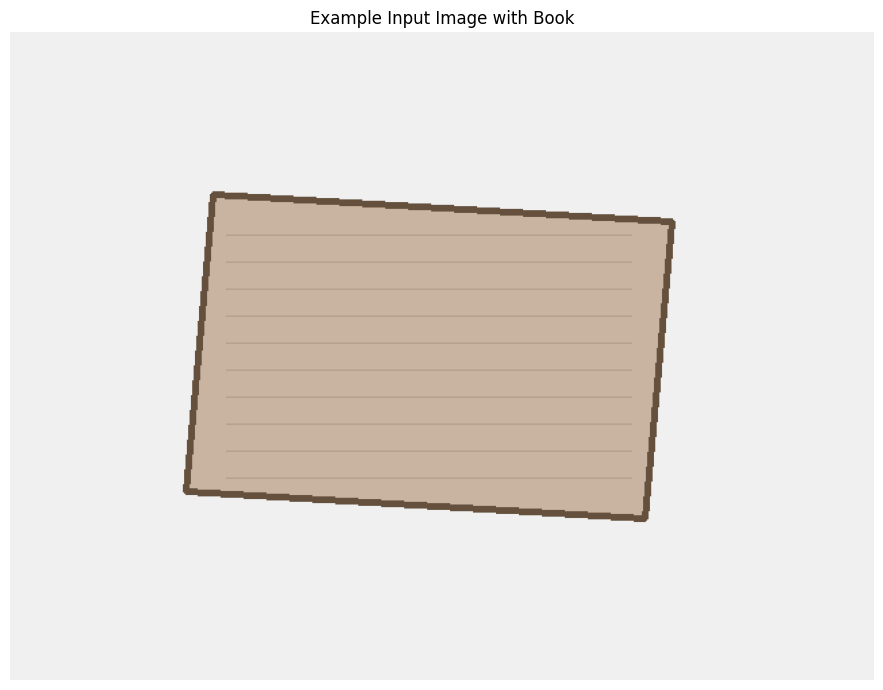

In [19]:
if __name__ == "__main__":
    print("\n" + "="*70)
    print(" "*15 + "AR WITH PYTORCH3D - ASSIGNMENT 4")
    print("="*70)

    # Check CUDA availability
    if torch.cuda.is_available():
        print(f"✓ CUDA Available: {torch.cuda.get_device_name(0)}")
    else:
        print("⚠ Running on CPU (CUDA not available)")

    # Run example pipeline
    print("\nRunning example pipeline to verify setup...")
    try:
        run_example_pipeline()
        print("\n✓ Example pipeline successful!")
    except Exception as e:
        print(f"\n⚠ Example pipeline error (this is OK): {e}")

    # Launch Gradio interface
    print("\n" + "="*70)
    print("LAUNCHING GRADIO INTERFACE...")
    print("="*70)
    print("\n📝 Instructions:")
    print("1. The interface will open in a new browser tab")
    print("2. Upload your image of a book/object on a desk")
    print("3. Click 4 corners: Top-Left → Top-Right → Bottom-Right → Bottom-Left")
    print("4. Adjust parameters and click 'Render'")
    print("\n" + "="*70 + "\n")

    # Create and launch interface
    demo = create_gradio_interface()
    demo.launch(
        share=True,  # Creates public link
        debug=False,
        show_error=True
    )

In [16]:
def save_camera_parameters(R, t, K, filename='camera_params.npz'):
    """Save camera parameters for later use"""
    np.savez(filename, R=R, t=t, K=K)
    print(f"✓ Camera parameters saved to {filename}")


def load_camera_parameters(filename='camera_params.npz'):
    """Load saved camera parameters"""
    data = np.load(filename)
    return data['R'], data['t'], data['K']


def visualize_camera_frustum(R, t, K, image_size, plane_points):
    """Visualize camera frustum and plane in 3D"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Camera center in world coordinates
    C = -R.T @ t

    # Draw camera
    ax.scatter(*C, c='red', s=100, marker='o', label='Camera')

    # Draw plane
    plane_points_3d = np.vstack([plane_points, plane_points[0]])
    ax.plot(plane_points_3d[:, 0], plane_points_3d[:, 1],
            plane_points_3d[:, 2], 'b-', linewidth=2, label='Plane')

    # Draw camera frustum
    h, w = image_size
    corners_2d = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)

    # Set axis labels and limits
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title('Camera Pose Visualization')

    plt.show()


def create_ar_video(video_path, corners_list, output_path='ar_video.mp4'):
    """Process video and add AR objects (bonus feature)"""
    print("Video processing feature - for advanced users")
    # This would require frame-by-frame processing
    # Left as an exercise for students wanting extra credit
    pass